In [132]:
import pandas as pd
import numpy as np
import os
import glob
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from operator import itemgetter
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer 
import gensim
import collections
import smart_open
import random
%matplotlib inline

# Preprocessing

## Create DataFrame

In [316]:
df = pd.read_csv('data/data_lettersfromgrandma.csv', index_col=False)
df

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,envelope,partial,postcard,postage,words,message_full,message_salutation,message_body,message_closing,url
0,1,1116,11/17/41,1941,1,Kelly Jones,0.0,Elizabeth Jones,unknown,unknown,...,1.0,0.0,0,NaN,306.0,"Dear Mom, Pop, ""etc"" (that means you too Franc...","Dear Mom, Pop, ""etc"" (that means you too Franc...",Miss O Ryan says I may come home Wednesday and...,"Love, Lizzie.",https://static1.squarespace.com/static/5ad67c3...
1,2,1117,12/5/45,1945,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,1.0,0.0,0,0.08,2081.0,Dearest Mom and Daddy. Your letter came about ...,Dearest Mom and Daddy.,"Your letter came about an hour ago, Mom. The t...","All my love, Betty.",https://static1.squarespace.com/static/5ad67c3...
2,3,1121,9/26/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,1.0,0.0,0,0.09,796.0,"Dearest Mom, Pop, and Kidlets. Mom your super-...","Dearest Mom, Pop, and Kidlets.","Mom your super-duper letters came, so will ans...","Once again, I must scoot to bed, soooo once ag...",https://static1.squarespace.com/static/5ad67c3...
3,4,1120,10/6/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Yoleta, TX","Yoleta, TX",...,1.0,0.0,0,0.03,863.0,"Dearest Mom, Pop, and kidlets. My little man i...","Dearest Mom, Pop, and kidlets.","My little man is writing to his folks, so I'll...","Lots of love from us both, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...
4,5,1119,10/8/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1.0,0.0,0,0.06,627.0,Dearest Folks. We got your super-duper letter ...,Dearest Folks.,"We got your super-duper letter yesterday, Mom,...","Lots of love, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...
5,6,1118,10/21/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1.0,0.0,0,0.02,1837.0,"Dearest Mom, Pop, and Kidlets. I'm lying on my...","Dearest Mom, Pop, and Kidlets.","I'm lying on my tummy on the bed, so if you ca...","Love, Betty.",https://static1.squarespace.com/static/5ad67c3...
6,7,1122,1/25/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1.0,0.0,0,0.05,1233.0,"Dear Fritzie. Mutt just brought your ""manuscri...",Dear Fritzie.,"Mutt just brought your ""manuscript"" home, and ...","Till next time, love from us both, Betty and M...",https://static1.squarespace.com/static/5ad67c3...
7,8,1123,9/6/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1.0,0.0,0,0.05,1214.0,"Dearest Mom, Pop, and family. I really hit the...","Dearest Mom, Pop, and family.",I really hit the jackpot yesterday!! Got a let...,"Till next time, all our love, Betty, Mutt, and...",https://static1.squarespace.com/static/5ad67c3...
8,9,1124,9/29/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Fort Jackson, SC",...,1.0,0.0,0,0.05,529.0,"Dear Grandma, Granddad, Auntie, and Uncles. We...","Dear Grandma, Granddad, Auntie, and Uncles.","Well, we dood it!!! Got the cutest little dark...","Love to all of you from the three of us, Butty...",https://static1.squarespace.com/static/5ad67c3...
9,10,1125,1/5/48,1948,1,Kelly Jones,0.0,Elizabeth Jones,"Shaw Field, SC","Shaw Field, SC",...,1.0,0.0,0,0.05,953.0,Dearest Folks. This is going to be a joint let...,Dearest Folks.,This is going to be a joint letter because I'd...,"Love from your ""rebels"", the South Carolina Jo...",https://static1.squarespace.com/static/5ad67c3...


In [317]:
df.shape

(365, 26)

In [318]:
# one df for all letters (df_all), another for just transcribed (df) where 'transcribed' == 1
df_all = df.copy()


df.dropna(subset=['message_full'], inplace=True)

In [319]:
df_all.shape # should have ~360 rows and 20-30 columns

(365, 26)

In [346]:
df.shape

(176, 28)

In [347]:
df.postcard.sum() # need to drop 5 postcards

5

In [349]:
df = df[df.postcard != 1] # drop 5 postcards
df.shape

(171, 28)

In [350]:
df = df.reset_index(drop=True)
df

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,postcard,postage,words,message_full,message_salutation,message_body,message_closing,url,polarity,subjectivity
0,1,1116,11/17/41,1941,1,Kelly Jones,0.0,Elizabeth Jones,unknown,unknown,...,0,NaN,306.0,"Dear Mom, Pop, ""etc"" (that means you too Franc...","Dear Mom, Pop, ""etc"" (that means you too Franc...",Miss O Ryan says I may come home Wednesday and...,"Love, Lizzie.",https://static1.squarespace.com/static/5ad67c3...,0.236419,0.510208
1,2,1117,12/5/45,1945,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,0,0.08,2081.0,Dearest Mom and Daddy. Your letter came about ...,Dearest Mom and Daddy.,"Your letter came about an hour ago, Mom. The t...","All my love, Betty.",https://static1.squarespace.com/static/5ad67c3...,0.242656,0.507861
2,3,1121,9/26/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,0,0.09,796.0,"Dearest Mom, Pop, and Kidlets. Mom your super-...","Dearest Mom, Pop, and Kidlets.","Mom your super-duper letters came, so will ans...","Once again, I must scoot to bed, soooo once ag...",https://static1.squarespace.com/static/5ad67c3...,0.096471,0.391965
3,4,1120,10/6/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Yoleta, TX","Yoleta, TX",...,0,0.03,863.0,"Dearest Mom, Pop, and kidlets. My little man i...","Dearest Mom, Pop, and kidlets.","My little man is writing to his folks, so I'll...","Lots of love from us both, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...,0.190564,0.433968
4,5,1119,10/8/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,0,0.06,627.0,Dearest Folks. We got your super-duper letter ...,Dearest Folks.,"We got your super-duper letter yesterday, Mom,...","Lots of love, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...,0.172017,0.469396
5,6,1118,10/21/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,0,0.02,1837.0,"Dearest Mom, Pop, and Kidlets. I'm lying on my...","Dearest Mom, Pop, and Kidlets.","I'm lying on my tummy on the bed, so if you ca...","Love, Betty.",https://static1.squarespace.com/static/5ad67c3...,0.125173,0.475836
6,7,1122,1/25/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,0,0.05,1233.0,"Dear Fritzie. Mutt just brought your ""manuscri...",Dear Fritzie.,"Mutt just brought your ""manuscript"" home, and ...","Till next time, love from us both, Betty and M...",https://static1.squarespace.com/static/5ad67c3...,0.202001,0.505821
7,8,1123,9/6/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,0,0.05,1214.0,"Dearest Mom, Pop, and family. I really hit the...","Dearest Mom, Pop, and family.",I really hit the jackpot yesterday!! Got a let...,"Till next time, all our love, Betty, Mutt, and...",https://static1.squarespace.com/static/5ad67c3...,0.194834,0.456406
8,9,1124,9/29/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Fort Jackson, SC",...,0,0.05,529.0,"Dear Grandma, Granddad, Auntie, and Uncles. We...","Dear Grandma, Granddad, Auntie, and Uncles.","Well, we dood it!!! Got the cutest little dark...","Love to all of you from the three of us, Butty...",https://static1.squarespace.com/static/5ad67c3...,0.116143,0.561554
9,10,1125,1/5/48,1948,1,Kelly Jones,0.0,Elizabeth Jones,"Shaw Field, SC","Shaw Field, SC",...,0,0.05,953.0,Dearest Folks. This is going to be a joint let...,Dearest Folks.,This is going to be a joint letter because I'd...,"Love from your ""rebels"", the South Carolina Jo...",https://static1.squarespace.com/static/5ad67c3...,0.255638,0.513883


In [351]:
df.shape # should have ~170 rows as of 6/18/18 for 170ish transcribed letters

(171, 28)

In [352]:
df.message_body.str.lower().to_frame().head()

,message_body
0,miss o ryan says i may come home wednesday and...
1,"your letter came about an hour ago, mom. the t..."
2,"mom your super-duper letters came, so will ans..."
3,"my little man is writing to his folks, so i'll..."
4,"we got your super-duper letter yesterday, mom,..."


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 28 columns):
letter_id             171 non-null int64
input_id              171 non-null int64
letter_date           171 non-null object
year                  171 non-null int64
transcribed           171 non-null int64
transcribed_by        171 non-null object
needs_formatting      171 non-null float64
sender                171 non-null object
sender_loc            171 non-null object
sender_loc_raw        171 non-null object
sender_latitude       168 non-null float64
sender_longitude      168 non-null float64
recipient             171 non-null object
recipient_loc         171 non-null object
rec_latitude          169 non-null float64
rec_longitude         169 non-null float64
envelope              158 non-null float64
partial               170 non-null float64
postcard              171 non-null int64
postage               107 non-null float64
words                 171 non-null float64
message_f

## Clean Text

In [354]:
def clean_column(colname):
    df[colname] = df[colname].str.replace(
        '’',"'").str.replace(
        '‘',"'").str.replace(
        '“','"').str.replace(
        '”','"').str.replace(
        '&', 'and').str.replace(
        'N Dak', 'North Dakota').str.replace(
        'Albuq.', 'Albuquerque').str.replace(
        'to-day','today').str.replace(
        'to-morrow','tomorrow').str.replace(
        'to-nite','tonight').str.replace(
        "s'pose",'suppose').str.replace(
        "S'pose", 'Suppose').str.replace(
        'Lt. Col.', 'Lieutenant Colonel').str.replace(
        'AFB', 'Air Force Base')

clean_column('message_full')
clean_column('message_salutation')
clean_column('message_body')
clean_column('message_closing')

In [355]:
print(df['message_full'][40]) # checking message cleaning

Greetings!!  I've got stuff that should be done, but feel like writing to you instead, so here goes!! First of all, for goodness sake don't worry about Richard's arm! It hasn't bothered him at all since a few minutes after he hurt it. The antics these kids go through every day would sure show up anything that might bother them, and he never favors it, so there's nothing wrong with it. The kids next door have a gymnasium set in the yard and the kids hold onto the bar and swing their feet, so if there were anything wrong with his arm that would surely bother him and it doesn't, so he's 100% O.K. Karen smashed her left hand in the car door Sunday night and thought she may have broken a bone in the back of her hand because it swelled up so fast, but she has good use of it. Her hand is still a little swollen and the back of  her hand and fingers are all purple, but it doesn't seem to bother her a bit. Funny how kids can get banged up and never seems to bother them. We're all waiting to hear

## Set Stop Words

In [356]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']
stop = set(stop)

# Exploratory NLP

## Sentence Tokenization

In [357]:
# from nltk.tokenize import sent_tokenize

text = df.message_body.astype(str).tolist()
sentences_list = [sent_tokenize(msg) for msg in text]
sentences_list

# original method: worked for single string, had to modify for list
# sentences = sent_tokenize(text_list)
# print(sentences)

[['Miss O Ryan says I may come home Wednesday and do not need to come back to work till Friday noon.',
  "Pretty good, don't you think so?",
  "Haven't seen Helen today, but Mrs Selland said that fam and Helen were in town 'cuz she saw you.",
  "Haven't had any mail except a letter from the corporal and one from the sailor last week.",
  "Suppose Helen won't be through until 6.",
  'I think that maybe I can get through by then, too.',
  'Got all my test papers back now.',
  "I told you some of the marks before, I think, but in case you'd like to know them all here goes: 91 Anatomy (3 kids flunked (below 65) and only 2 others above 90), 98 Ethics, 98 Nursing Arts, 100 Medical Nursing.",
  'Thelma Selling had her appendix removed this morning.',
  'She is feeling pretty good.',
  'Course she has quite a bit of pain yet.',
  '"Mama Gene" came out of her operation fine.',
  "She has a lot of pain though, but that's expected.",
  "They're both grand patients.",
  'Mrs Joe Bakn is also okay.

## TextBlob Sentiment

In [358]:
# from textblob import TextBlob

In [359]:
# test sentiment on diff letters
for msg in df.message_body.tolist():
    print(msg)
    print()
    print(TextBlob(msg).sentiment)
    print()
    print()

Miss O Ryan says I may come home Wednesday and do not need to come back to work till Friday noon. Pretty good, don't you think so? Haven't seen Helen today, but Mrs Selland said that fam and Helen were in town 'cuz she saw you. Haven't had any mail except a letter from the corporal and one from the sailor last week. Suppose Helen won't be through until 6. I think that maybe I can get through by then, too. Got all my test papers back now. I told you some of the marks before, I think, but in case you'd like to know them all here goes: 91 Anatomy (3 kids flunked (below 65) and only 2 others above 90), 98 Ethics, 98 Nursing Arts, 100 Medical Nursing. Thelma Selling had her appendix removed this morning. She is feeling pretty good. Course she has quite a bit of pain yet. "Mama Gene" came out of her operation fine. She has a lot of pain though, but that's expected. They're both grand patients. Mrs Joe Bakn is also okay. Mrs Robert Peterson from Knox has a baby girl and she named it "Betty Lo


Sentiment(polarity=0.13437270834811815, subjectivity=0.48096279858574936)


Good morning! Parma drinking coffee and eating donuts, kids in bed and all is quiet. Guess what! Santa Claus came to our house again! This time on Dec. 31st. Sure was nice that your package came a little later than the rest. Think the kids enjoy each pkg. a little more when they don't get here all at once. Karen's blouse fits to a T, and she's worn that white slip ever since she got it! Hope to get it off her on wash day. The kids all sat right down on the floor and played "cars" with Rodney's cars and our little dummy rand around shaking the dumbell! I was in the midst of washing when the pkg. came and Karen came lugging it out to the clothesline yelling "Look what we got, Mommie! He did it again!" I said, "Who did what again?" and she says, "Santa Clause! He sent us another pkg!" 9:30 A.M. The kids all got up, so had to quit. Mark has cried ever since he got up, so he's in bed, mad as a hornet! Got the kids 

Sentiment(polarity=0.08617384437407585, subjectivity=0.5248912404467959)


Lost my pen someplace so "Sheiler v Steiler" is writing this. Works good, too! I have had the best jelly for supper tonight on our toast! It was "Grandma jelly". Kids do not refer to it by flavor. It is just "grandma" jelly, the best in the world in our opinion. Mutt came in with the groceries the other night and I was attempting to make lefse (did not look nor taste like lefse but we ate most of it anyway), so the stinker did not tell me four packages were out in the car because he knew I would drop the lefse stuff or let it burn and first thing you know, he very nonchalantly says, "Well, guess I can bring in your mother's package now!" I darned near threw him out and in he comes with the packages. Think we had twice as much fun as we would have if it had come in the midst of all the other Xmas things. I do not know where to start with the thank you's! There was too much to mention everything! The twins clothes

Pa is off to work, Mark is off to school, Doug and the double trouble eating the last of their bacon and eggs, and Karen frosting some graham crackers to use up some left over frosting. Guess that accounts for everyone but Ma, and she's not dressed yet, but decided she wanted to talk to her own Ma and Pa for a while, so here I am! Was so excited when Mr. Nelson called from the Grand Forke Herald! I sat here Monday morning and got the information sorted and written up and it took me from 8:30A.M. to 1P.M.! Not that it was a masterpiece, but what with interruptions and all, I was determined to get it written up whether anything else got done or not! Had about decided that they'd decided to throw it out, and then the phone rang! They better do my Father justice, too, or I'll shoot them!! I could tell them lots of things about him if they'd only ask me. I'd tell them, too, that he beats his children with leather bedroom slippers and that he can spell b-u-s-t "bust"!! Now that's history, is


Mark and Doug are gone and Rich doesn't get up until 9 this morning. Mark came home from classes at 11 AM Friday with a temp of 101.6 and it was 103 degrees all day Saturday and the doctor says "flu", so he's back to school today. He's still blowing his nose like mad, and coughing a little, but his temp was normal all day yesterday and he even "looks" like Mark today. Yesterday the Scouts had a meeting here at 10 AM and the Scoutmaster was here till 4 PM. He's a young fellow, about 25, getting married December 21, and Mark is his assistant Scoutmaster and I could tell Ed just didn't want to go back to his barracks. He's a nice young man and really good with the Scouts. Karen and Jim were over Sunday evening and we just gabbed and gabbed. Jim plans to go to Long Beach State College next year, so they'll be moving next summer. It sure has been nice to have them close this year. Mutt is supposed to find out this week sometime about where his job will be and we're sure anxious! He is in a

In [360]:
sentmtlist = [TextBlob(msg).sentiment for msg in df.message_body.tolist()]

In [361]:
len(sentmtlist)

171

In [362]:
sentmtlist

[Sentiment(polarity=0.23641927083333333, subjectivity=0.5102083333333334),
 Sentiment(polarity=0.24265562286775033, subjectivity=0.5078614909740737),
 Sentiment(polarity=0.09647114706737335, subjectivity=0.3919649943310657),
 Sentiment(polarity=0.1905641310196395, subjectivity=0.4339682539682541),
 Sentiment(polarity=0.17201665521978024, subjectivity=0.4693959223646724),
 Sentiment(polarity=0.12517263215179875, subjectivity=0.475836385836386),
 Sentiment(polarity=0.20200136707544453, subjectivity=0.5058210938994071),
 Sentiment(polarity=0.19483392287649884, subjectivity=0.45640571083505876),
 Sentiment(polarity=0.11614266103728313, subjectivity=0.5615540789959395),
 Sentiment(polarity=0.25563768461930225, subjectivity=0.513883116883117),
 Sentiment(polarity=0.25494791666666666, subjectivity=0.4814484126984127),
 Sentiment(polarity=0.15459674873737372, subjectivity=0.5588383838383838),
 Sentiment(polarity=0.021672786125911118, subjectivity=0.39697802197802196),
 Sentiment(polarity=0.161

In [363]:
df_sentmt = pd.DataFrame(sentmtlist)
df_sentmt.head()

,polarity,subjectivity
0,0.236419,0.510208
1,0.242656,0.507861
2,0.096471,0.391965
3,0.190564,0.433968
4,0.172017,0.469396


In [364]:
df_sentmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
polarity        171 non-null float64
subjectivity    171 non-null float64
dtypes: float64(2)
memory usage: 2.8 KB


In [365]:
df_sentmt.describe()

,polarity,subjectivity
count,171.000000,171.000000
mean,0.135006,0.480115
std,0.064536,0.052043
min,-0.051167,0.350899
25%,0.095035,0.448583
50%,0.136114,0.480414
75%,0.184155,0.514513
max,0.268641,0.630519


In [366]:
df_sentmt.index = df.index # synchronize indices so they concatenate nicely, since order is same
df = pd.concat([df, df_sentmt], axis=1)

df

,letter_id,input_id,letter_date,year,transcribed,transcribed_by,needs_formatting,sender,sender_loc,sender_loc_raw,...,words,message_full,message_salutation,message_body,message_closing,url,polarity,subjectivity,polarity,subjectivity
0,1,1116,11/17/41,1941,1,Kelly Jones,0.0,Elizabeth Jones,unknown,unknown,...,306.0,"Dear Mom, Pop, ""etc"" (that means you too Franc...","Dear Mom, Pop, ""etc"" (that means you too Franc...",Miss O Ryan says I may come home Wednesday and...,"Love, Lizzie.",https://static1.squarespace.com/static/5ad67c3...,0.236419,0.510208,0.236419,0.510208
1,2,1117,12/5/45,1945,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,2081.0,Dearest Mom and Daddy. Your letter came about ...,Dearest Mom and Daddy.,"Your letter came about an hour ago, Mom. The t...","All my love, Betty.",https://static1.squarespace.com/static/5ad67c3...,0.242656,0.507861,0.242656,0.507861
2,3,1121,9/26/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Riverside, CA","Riverside, CA",...,796.0,"Dearest Mom, Pop, and Kidlets. Mom your super-...","Dearest Mom, Pop, and Kidlets.","Mom your super-duper letters came, so will ans...","Once again, I must scoot to bed, soooo once ag...",https://static1.squarespace.com/static/5ad67c3...,0.096471,0.391965,0.096471,0.391965
3,4,1120,10/6/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"Yoleta, TX","Yoleta, TX",...,863.0,"Dearest Mom, Pop, and kidlets. My little man i...","Dearest Mom, Pop, and kidlets.","My little man is writing to his folks, so I'll...","Lots of love from us both, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...,0.190564,0.433968,0.190564,0.433968
4,5,1119,10/8/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,627.0,Dearest Folks. We got your super-duper letter ...,Dearest Folks.,"We got your super-duper letter yesterday, Mom,...","Lots of love, Betty and Mutt.",https://static1.squarespace.com/static/5ad67c3...,0.172017,0.469396,0.172017,0.469396
5,6,1118,10/21/46,1946,1,Kelly Jones,0.0,Elizabeth Jones,"El Paso, TX","El Paso, TX",...,1837.0,"Dearest Mom, Pop, and Kidlets. I'm lying on my...","Dearest Mom, Pop, and Kidlets.","I'm lying on my tummy on the bed, so if you ca...","Love, Betty.",https://static1.squarespace.com/static/5ad67c3...,0.125173,0.475836,0.125173,0.475836
6,7,1122,1/25/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1233.0,"Dear Fritzie. Mutt just brought your ""manuscri...",Dear Fritzie.,"Mutt just brought your ""manuscript"" home, and ...","Till next time, love from us both, Betty and M...",https://static1.squarespace.com/static/5ad67c3...,0.202001,0.505821,0.202001,0.505821
7,8,1123,9/6/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Sumter, SC",...,1214.0,"Dearest Mom, Pop, and family. I really hit the...","Dearest Mom, Pop, and family.",I really hit the jackpot yesterday!! Got a let...,"Till next time, all our love, Betty, Mutt, and...",https://static1.squarespace.com/static/5ad67c3...,0.194834,0.456406,0.194834,0.456406
8,9,1124,9/29/47,1947,1,Kelly Jones,0.0,Elizabeth Jones,"Sumter, SC","Fort Jackson, SC",...,529.0,"Dear Grandma, Granddad, Auntie, and Uncles. We...","Dear Grandma, Granddad, Auntie, and Uncles.","Well, we dood it!!! Got the cutest little dark...","Love to all of you from the three of us, Butty...",https://static1.squarespace.com/static/5ad67c3...,0.116143,0.561554,0.116143,0.561554
9,10,1125,1/5/48,1948,1,Kelly Jones,0.0,Elizabeth Jones,"Shaw Field, SC","Shaw Field, SC",...,953.0,Dearest Folks. This is going to be a joint let...,Dearest Folks.,This is going to be a joint letter because I'd...,"Love from your ""rebels"", the South Carolina Jo...",https://static1.squarespace.com/static/5ad67c3...,0.255638,0.513883,0.255638,0.513883


In [367]:
df.to_csv('data/data_lettersfromgrandma_indivletter.csv')

## n-Grams

In [368]:
# from nltk.util import ngrams
# from collections import Counter
# from operator import itemgetter
# from nltk.corpus import stopwords

**Unigrams**

In [374]:
# adapted from bigrams code below - may be better way to do this for single words
stop2 = stopwords.words('english')
stop2 += ['.', ',', '(', ')', "'", '"','’','”','“', "'s", "n't", "'ll", "'d", "'re", "'m", "'ve", 'ta']
stop2 = set(stop2)

counter = Counter()

messages = df.message_body.str.lower()

n = 1
for msg in messages:
    words = TextBlob(msg).words
    words = [w for w in words if w not in stop2]
    word = ngrams(words, n)
    counter += Counter(word)

for phrase, count in counter.most_common(150):
    print('%20s %i' % (" ".join(phrase), count))

                 get 953
                 got 839
                 one 554
                time 518
                mutt 503
                  go 439
                know 423
                said 415
                 see 404
                like 401
                home 395
               going 394
                sure 390
                back 379
                good 376
              little 375
                 day 370
                kids 347
               would 334
                  us 327
               karen 319
               night 304
                last 288
              really 284
             morning 278
               could 277
                well 273
                went 270
               think 265
           yesterday 258
                came 251
              school 251
                come 241
                much 236
                work 235
                mark 232
                till 228
              letter 226
                boys 224
               still 223


**Bigrams**

In [373]:
counter = Counter()

messages = df.message_body.str.lower()

n = 2
for msg in messages:
    words = TextBlob(msg).words
    words = [w for w in words if w not in stop2]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

          last night 107
              gon na 55
           came home 50
          better get 45
        north dakota 43
              see us 40
           come home 39
            come see 37
         living room 37
             got get 36
           last week 35
           could get 33
           next door 32
         pretty good 31
            got home 31
          looks like 31
           every day 31
              got go 30
          got letter 30
           next week 29
           air force 28
           came back 28
             one day 28
             go work 28
          every time 28
            let know 28
           uncle gus 27
         couple days 27
            time get 26
            get home 25
              oh yes 25
            one days 24
             etc etc 24
           mutt went 24
         grand forks 24
            mutt got 24
          would like 23
            got back 22
           come back 21
           years old 21
           sure glad 21
           look

**Trigrams**

In [375]:
counter = Counter()

messages = df.message_body.str.lower()

n = 3
for msg in messages:
    words = TextBlob(msg).words
    words = [w for w in words if w not in stop2]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)

for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

         come see us 26
         etc etc etc 12
      air force base 12
      happy new year 11
         heh heh heh 11
      mutt came home 10
    couple weeks ago 10
        got get busy 9
     get dressed get 8
     sure would like 7
       going try get 7
       coming see us 7
    guess better get 7
         let us know 7
      go get dressed 7
work thursday friday 7
     first time ever 6
      ever since got 6
            ha ha ha 6
          gon na get 5
  well reckon better 5
got tribune yesterday 5
   supper last night 5
           gon na go 5
  happy birthday mom 5
      mutt left work 5
   dining room table 5
owe everyone letters 5
  better get dressed 5
   mother day father 5
      day father day 5
 air defense command 5
       better go get 5
church sunday morning 4
       get home till 4
      would like see 4
     guess better go 4
         gon na sign 4
 living room kitchen 4
        well got get 4
letter came yesterday 4
        got get work 4
       sure good get 4
 

## TF-IDF

Used this resource for tf-idf: https://sigdelta.com/blog/text-analysis-in-pandas/  

Used this resource to make df with row per sentence:  
https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

In [376]:
# keep only letter id and body text (no salutation/closing)
df_sent = df[['letter_id','message_body']].copy()
df_sent.head()

,letter_id,message_body
0,1,Miss O Ryan says I may come home Wednesday and...
1,2,"Your letter came about an hour ago, Mom. The t..."
2,3,"Mom your super-duper letters came, so will ans..."
3,4,"My little man is writing to his folks, so I'll..."
4,5,"We got your super-duper letter yesterday, Mom,..."


In [377]:
# explode df by sentence

# SOURCE: https://stackoverflow.com/questions/12680754/
# split-explode-pandas-dataframe-string-entry-to-separate-rows

def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

def split_df(dataframe, col_name, sep):
    orig_col_index = dataframe.columns.tolist().index(col_name)
    orig_index_name = dataframe.index.name
    orig_columns = dataframe.columns
    dataframe = dataframe.reset_index()  # we need a natural 0-based index for proper merge
    index_col_name = (set(dataframe.columns) - set(orig_columns)).pop()
    df_split = pd.DataFrame(
        pd.DataFrame(dataframe[col_name].str.split(sep).tolist())
        .stack().reset_index(level=1, drop=1), columns=[col_name])
    df = dataframe.drop(col_name, axis=1)
    df = pd.merge(df, df_split, left_index=True, right_index=True, how='inner')
    df = df.set_index(index_col_name)
    df.index.name = orig_index_name
    # merge adds the column to the last place, so we need to move it back
    return change_column_order(df, col_name, orig_col_index)

df_sent = split_df(df_sent, 'message_body', '.')
df_sent.head(50)

,letter_id,message_body
0,1,Miss O Ryan says I may come home Wednesday and...
0,1,"Pretty good, don't you think so? Haven't seen..."
0,1,Haven't had any mail except a letter from the...
0,1,Suppose Helen won't be through until 6
0,1,"I think that maybe I can get through by then,..."
0,1,Got all my test papers back now
0,1,"I told you some of the marks before, I think,..."
0,1,Thelma Selling had her appendix removed this ...
0,1,She is feeling pretty good
0,1,Course she has quite a bit of pain yet


In [378]:
df_sent.shape

(7275, 2)

In [379]:
# Some used imports
# %matplotlib inline
# import pandas as pd
# import numpy as np
# import os
# import glob
# import matplotlib as mpl

# Just making the plots look better
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 12

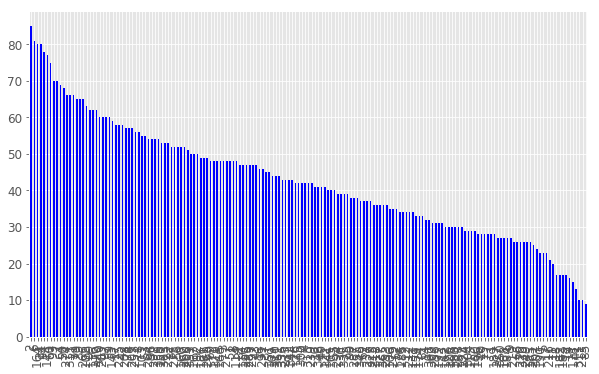

In [380]:
# bar chart of letter lengths in sentences
df_sent['letter_id'].value_counts().plot.bar(color='blue')

In [381]:
df_sent['words'] = df_sent.message_body.str.strip().str.split('[\W]+')
df_sent.head()

,letter_id,message_body,words
0,1,Miss O Ryan says I may come home Wednesday and...,"[Miss, O, Ryan, says, I, may, come, home, Wedn..."
0,1,"Pretty good, don't you think so? Haven't seen...","[Pretty, good, don, t, you, think, so, Haven, ..."
0,1,Haven't had any mail except a letter from the...,"[Haven, t, had, any, mail, except, a, letter, ..."
0,1,Suppose Helen won't be through until 6,"[Suppose, Helen, won, t, be, through, until, 6]"
0,1,"I think that maybe I can get through by then,...","[I, think, that, maybe, I, can, get, through, ..."


In [382]:
rows = list()
for row in df_sent[['letter_id', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.letter_id, word))

words = pd.DataFrame(rows, columns=['letter_id', 'word'])
words.head(20)

,letter_id,word
0,1,Miss
1,1,O
2,1,Ryan
3,1,says
4,1,I
5,1,may
6,1,come
7,1,home
8,1,Wednesday
9,1,and


In [383]:
words.shape

(152572, 2)

In [384]:
# remove lines with length 0 (empty lines)
words = words[words.word.str.len() > 0]
words.head()

,letter_id,word
0,1,Miss
1,1,O
2,1,Ryan
3,1,says
4,1,I


In [385]:
words.shape # now fewer rows

(151928, 2)

In [386]:
# make words lowercase
words['word'] = words.word.str.lower()
words.head()

,letter_id,word
0,1,miss
1,1,o
2,1,ryan
3,1,says
4,1,i


In [387]:
# count of each word per book
counts = words.groupby('letter_id')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts.head()

n_w
letter_id word     
1         the    11
          and     8
          i       7
          of      7
          a       6

In [388]:
# top n words per letter
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
#     r.plot.bar()
    return r.to_frame()


pretty_plot_top_n(counts['n_w'])

n_w
letter_id word     
1         the    11
          and     8
          i       7
          of      7
          a       6
2         i     152
          and    83
          that   68
          to     62
          t      55
3         and    34
          the    33
          i      27
          to     24
          a      16
4         and    38
          to     31
          i      28
          the    27
          it     18
5         and    38
          the    30
          i      19
          a      13
          to     13
6         and    99
          the    65
          i      61
          to     54
          a      32
...             ...
351       and    39
          a      31
          the    31
          to     28
          it     22
353       and    52
          the    35
          to     29
          a      28
          i      23
359       to     31
          and    29
          it     24
          the    24
          he     21
361       and    39
          to     27
          the    24
          in     18
          i      16
363       and    46
          to     41
          the    40
          he     35
          a      30
365       and    40
          a      27
          to     20
          she    18
          the    17

[855 rows x 1 columns]

In [389]:
# get counts for each letter
word_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_w': 'n_d'})
word_sum

,n_d
letter_id,
1,307
2,2176
3,805
4,895
5,650
6,1908
7,1272
8,1260
9,530


In [390]:
# join on letter id to get sum of word per letter
tf = counts.join(word_sum)
tf['tf'] = tf.n_w/tf.n_d
tf.head()

n_w  n_d        tf
letter_id word                    
1         the    11  307  0.035831
          and     8  307  0.026059
          i       7  307  0.022801
          of      7  307  0.022801
          a       6  307  0.019544

In [391]:
# mostly stop words so far
pretty_plot_top_n(tf['tf'])

tf
letter_id word          
1         the   0.035831
          and   0.026059
          i     0.022801
          of    0.022801
          a     0.019544
2         i     0.069853
          and   0.038143
          that  0.031250
          to    0.028493
          t     0.025276
3         and   0.042236
          the   0.040994
          i     0.033540
          to    0.029814
          a     0.019876
4         and   0.042458
          to    0.034637
          i     0.031285
          the   0.030168
          it    0.020112
5         and   0.058462
          the   0.046154
          i     0.029231
          a     0.020000
          to    0.020000
6         and   0.051887
          the   0.034067
          i     0.031971
          to    0.028302
          a     0.016771
...                  ...
351       and   0.038614
          a     0.030693
          the   0.030693
          to    0.027723
          it    0.021782
353       and   0.049761
          the   0.033493
          to    0.027751
          a     0.026794
          i     0.022010
359       to    0.032874
          and   0.030753
          it    0.025451
          the   0.025451
          he    0.022269
361       and   0.050258
          to    0.034794
          the   0.030928
          in    0.023196
          i     0.020619
363       and   0.038365
          to    0.034195
          the   0.033361
          he    0.029191
          a     0.025021
365       and   0.048019
          a     0.032413
          to    0.024010
          she   0.021609
          the   0.020408

[855 rows x 1 columns]

In [392]:
# get number of letters
c_d = words.letter_id.nunique()
c_d

171

In [393]:
# number of unique books every term appeared in
idf = words.groupby('word')\
    .letter_id\
    .nunique()\
    .to_frame()\
    .rename(columns={'letter_id':'i_d'})\
    .sort_values('i_d')
idf.head()

,i_d
word,
ω,1
regional,1
regards,1
regardless,1
former,1


In [394]:
# calculate idf as new column
idf['idf'] = np.log(c_d/idf.i_d.values)
idf.head()

,i_d,idf
word,,
ω,1,5.141664
regional,1,5.141664
regards,1,5.141664
regardless,1,5.141664
former,1,5.141664


In [395]:
# get final dataframe by joining tf and idf
tf_idf = tf.join(idf)
tf_idf.head()

n_w  n_d        tf  i_d       idf
letter_id word                                   
1         the    11  307  0.035831  171  0.000000
          and     8  307  0.026059  170  0.005865
          i       7  307  0.022801  170  0.005865
          of      7  307  0.022801  170  0.005865
          a       6  307  0.019544  171  0.000000

In [396]:
# calculate tf-idf statistic
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
tf_idf.head()

n_w  n_d        tf  i_d       idf    tf_idf
letter_id word                                             
1         the    11  307  0.035831  171  0.000000  0.000000
          and     8  307  0.026059  170  0.005865  0.000153
          i       7  307  0.022801  170  0.005865  0.000134
          of      7  307  0.022801  170  0.005865  0.000134
          a       6  307  0.019544  171  0.000000  0.000000

In [397]:
pretty_plot_top_n(tf_idf['tf_idf'])

tf_idf
letter_id word                 
1         98           0.033496
          bailey       0.033496
          stenson      0.033496
          nursing      0.023011
          pain         0.019949
2         loved        0.014609
          engagement   0.014310
          love         0.010605
          fay          0.008656
          duane        0.008177
3         ribbon       0.035157
          sib          0.016004
          campaign     0.012774
          excuses      0.012774
          sugar        0.011910
4         honey        0.012588
          miller       0.011490
          apartment    0.010317
          court        0.010264
          kocian       0.009941
5         cotton       0.036076
          raw          0.018660
          seeds        0.018660
          hayrack      0.015821
          soooo        0.014579
6         sooooo       0.009259
          mrs          0.007760
          johnson      0.007440
          el           0.005554
          paso         0.005554
...                         ...
351       claremont    0.013213
          personnel    0.011155
          diego        0.009492
          colonial     0.008809
          escondido    0.008809
353       utility      0.012771
          beverly      0.009841
          lanes        0.009841
          job          0.009566
          stove        0.009174
359       mention      0.013556
          offer        0.010167
          tax          0.009435
          upset        0.008575
          cause        0.007965
361       sealing      0.026503
          dental       0.013656
          950          0.013252
          mins         0.013252
          800          0.010420
363       procedures   0.012865
          graduate     0.011131
          scholarship  0.011131
          walker       0.011131
          quarter      0.010116
365       progress     0.019182
          walker       0.016021
          sauce        0.012345
          sauerkraut   0.012345
          giggles      0.009707

[855 rows x 1 columns]

# Changing Pronouns

https://github.com/huggingface/neuralcoref  
https://spacy.io/usage/models

In [110]:
# ! pip install -U spacy

In [111]:
# run once
import spacy
import en_core_web_lg
from neuralcoref import Coref

spacy = en_core_web_lg.load()
coref = Coref(nlp=spacy)

Loading neuralcoref model from /Users/kellyjones/anaconda3/lib/python3.6/site-packages/neuralcoref/weights/
Loading embeddings from /Users/kellyjones/anaconda3/lib/python3.6/site-packages/neuralcoref/weights/static_word
Loading embeddings from /Users/kellyjones/anaconda3/lib/python3.6/site-packages/neuralcoref/weights/tuned_word


In [290]:
def replace_pronouns(text):
    coref.one_shot_coref(text)
    return coref.get_resolved_utterances()[0]

In [291]:
# dataframe for pronouns
df_pron = df[['letter_id','message_body']].copy()
df_pron.head()

,letter_id,message_body
0,1,Miss O Ryan says I may come home Wednesday and...
1,2,"Your letter came about an hour ago, Mom. The t..."
2,3,"Mom your super-duper letters came, so will ans..."
3,4,"My little man is writing to his folks, so I'll..."
4,5,"We got your super-duper letter yesterday, Mom,..."


In [292]:
python -m spacy download en_core_web_sm
>>> import spacy
>>> nlp = spacy.load('en_core_web_sm')

SyntaxError: invalid syntax (<ipython-input-292-13a26074a61b>, line 1)

In [ ]:
# df_pron['message_body_pronouns'] = df_pron['message_body'].apply(lambda x: replace_pronouns(x))
# df_pron.head()

In [ ]:
replace_pronouns('Sam went to the store. He is happy.')

# Salutations and Closings

## Salutation n-grams

In [398]:
df.columns

Index(['letter_id', 'input_id', 'letter_date', 'year', 'transcribed',
       'transcribed_by', 'needs_formatting', 'sender', 'sender_loc',
       'sender_loc_raw', 'sender_latitude', 'sender_longitude', 'recipient',
       'recipient_loc', 'rec_latitude', 'rec_longitude', 'envelope', 'partial',
       'postcard', 'postage', 'words', 'message_full', 'message_salutation',
       'message_body', 'message_closing', 'url', 'polarity', 'subjectivity',
       'polarity', 'subjectivity'],
      dtype='object')

**Unigrams**

In [399]:
salutations = df.message_salutation.str.lower()
salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"','’','”','“']
stop = set(stop)

counter = Counter()

n = 1

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

                dear 77
                 mom 72
                good 68
             morning 62
               daddy 35
                 pop 23
             dearest 21
               folks 18
              mother 13
                mine 8
              mither 5
           greetings 4
           afternoon 4
                fine 4
             kidlets 3
               happy 3
                 etc 2
               means 2
                 fay 2
               hello 2
                 sal 2
                mugs 2
              dreges 2
                   n 2
               howdy 2
              mudder 2
              fodder 2
                mama 2
              easter 2
              father 2
             frances 1
             fritzie 1
              family 1
             grandma 1
            granddad 1
              auntie 1
              uncles 1
                  hi 1
                miss 1
               uncle 1


**Bigrams**

In [400]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 2

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

        good morning 62
            dear mom 50
           mom daddy 31
             mom pop 19
         dearest mom 10
       dearest folks 10
      morning mother 9
         morning mom 8
          dear folks 7
         mother mine 6
      good afternoon 4
      morning mither 4
         pop kidlets 3
            dear pop 3
          dear daddy 3
        morning dear 3
         dear mother 3
             pop etc 2
           etc means 2
            sal mugs 2
           daddy mom 2
        morning fine 2
        morning good 2
        happy easter 2
       mother father 2
           good good 2
       means frances 1
        dear fritzie 1
          pop family 1
        dear grandma 1
    grandma granddad 1
     granddad auntie 1
       auntie uncles 1
             hi miss 1
            miss fay 1
         means uncle 1
           uncle leo 1
afternoon grandfather 1
     grandfather fay 1
 greetings everybody 1


**Trigrams**

In [401]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 3

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

      dear mom daddy 29
        dear mom pop 11
 good morning mother 9
     dearest mom pop 8
    good morning mom 8
 morning mother mine 6
 good morning mither 4
     mom pop kidlets 3
   good morning dear 3
 morning dear mother 3
         mom pop etc 2
       pop etc means 2
   dearest mom daddy 2
      dear daddy mom 2
   good morning fine 2
   good morning good 2
morning good morning 2
  dear mother father 2
   good good morning 2
   etc means frances 1
      mom pop family 1
dear grandma granddad 1
grandma granddad auntie 1
granddad auntie uncles 1
         hi miss fay 1
     etc means uncle 1
     means uncle leo 1
good afternoon grandfather 1
afternoon grandfather fay 1
        mom pop kids 1
  good morning mater 1
 morning mater pater 1
good afternoon darling 1
        dear pop sal 1
        pop sal mugs 1
    dear drege folks 1
  good morning daddy 1
      happy new year 1
       mom daddy sal 1
      daddy sal mugs 1


**4-Grams**

In [402]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 4

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

good morning mother mine 6
dearest mom pop kidlets 3
good morning dear mother 3
   mom pop etc means 2
good morning good morning 2
morning dear mother father 2
    dear mom pop etc 1
pop etc means frances 1
dearest mom pop family 1
dear grandma granddad auntie 1
grandma granddad auntie uncles 1
 dearest mom pop etc 1
 pop etc means uncle 1
 etc means uncle leo 1
good afternoon grandfather fay 1
dearest mom pop kids 1
good morning mater pater 1
   dear pop sal mugs 1
  dear mom daddy sal 1
  mom daddy sal mugs 1
daddy sal mugs dreges 1
sal mugs dreges mongers 1
mugs dreges mongers f 1
dreges mongers f fays 1
dear patty pistrissa le 1
patty pistrissa le roy 1
pistrissa le roy little 1
le roy little female 1
roy little female cherubs 1
dear wabbits elephants e'er 1
wabbits elephants e'er case 1
elephants e'er case may 1
    e'er case may ha 1
      dear pop n mom 1
      dear mom n pop 1
dear parents laziest woman 1
parents laziest woman johnson 1
laziest woman johnson air 1
woman johnson

**5-Grams**

In [403]:
# salutations = df.message_salutation.str.lower()
# salutations = [str(sal) for sal in salutations] # string because numbers came thru as floats

counter = Counter()

n = 5

for sal in salutations:
    sal_words = TextBlob(sal).words
    sal_words = [w for w in sal_words if w not in stop]
    results = ngrams(sal_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(50):
    print('%20s %i' % (" ".join(phrase), count))

good morning dear mother father 2
dear mom pop etc means 1
mom pop etc means frances 1
dear grandma granddad auntie uncles 1
dearest mom pop etc means 1
mom pop etc means uncle 1
pop etc means uncle leo 1
dear mom daddy sal mugs 1
mom daddy sal mugs dreges 1
daddy sal mugs dreges mongers 1
sal mugs dreges mongers f 1
mugs dreges mongers f fays 1
dear patty pistrissa le roy 1
patty pistrissa le roy little 1
pistrissa le roy little female 1
le roy little female cherubs 1
dear wabbits elephants e'er case 1
wabbits elephants e'er case may 1
elephants e'er case may ha 1
dear parents laziest woman johnson 1
parents laziest woman johnson air 1
laziest woman johnson air force 1
woman johnson air force base 1
good morning fine fader mader 1
howdy mine fine papa mama 1
good good morning mother mine 1
good morning mother mine happy 1
morning mother mine happy easter 1


## Closing n-grams

**Unigrams**

In [404]:
closings = df.message_closing.str.lower()
closings = [str(clo) for clo in closings] # string because numbers came thru as floats

stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"','’','”','“']
stop = set(stop)

counter = Counter()

n = 1

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(100):
    print('%20s %i' % (" ".join(phrase), count))

                love 168
               betty 146
                  us 71
                lots 39
                mutt 34
                much 30
                 liz 16
              family 13
               karen 9
           toodle-oo 9
                kids 9
                time 6
                 ann 6
                next 4
             joneses 4
                  's 4
            'lizbeth 4
                till 3
                   6 3
           menagerie 3
              rodney 3
             richard 3
               jones 3
            chilluns 3
            children 3
                   n 3
              lizzie 2
                boys 2
              pounds 2
                   4 2
              ounces 2
               haste 2
              little 2
            leeshbit 2
                mark 2
                 got 2
                  ta 2
               chief 2
               think 2
               hurry 2
                soon 2
                doug 2
                tina 2
 

**Bigrams**

In [405]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 2

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

          love betty 70
             love us 69
            us betty 56
           lots love 33
          betty mutt 32
           much love 20
           much much 10
              us liz 8
          mutt karen 7
            love liz 7
        betty family 6
         mutt family 6
      toodle-oo love 5
           mutt kids 5
           time love 4
       joneses betty 4
       love 'lizbeth 4
        'lizbeth ann 4
           till next 3
           next time 3
          kids betty 3
        love joneses 3
         love lizzie 2
      mutt menagerie 2
        karen rodney 2
            6 pounds 2
         family love 2
       love leeshbit 2
      rodney richard 2
        richard mark 2
              got ta 2
   children children 2
     betty toodle-oo 2
         betty think 2
         hurry betty 2
           soon love 2
           doug tina 2
             lots 'n 2
             'n lots 2
              lots n 2


**Trigrams**

In [406]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 3

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

       love us betty 56
     lots love betty 18
     love betty mutt 14
        lots love us 13
       us betty mutt 11
     much love betty 11
      much much love 10
         love us liz 8
    betty mutt karen 7
        much love us 6
   betty mutt family 5
     betty mutt kids 5
   love betty family 4
   love 'lizbeth ann 4
      till next time 3
      next time love 3
     time love betty 3
  joneses betty mutt 3
  love joneses betty 3
betty mutt menagerie 2
   mutt karen rodney 2
     kids betty mutt 2
     us betty family 2
 rodney richard mark 2
   toodle-oo love us 2
  much love 'lizbeth 2
     soon love betty 2
        lots 'n lots 2
        'n lots love 2
         lots n lots 2
      must scoot bed 1
     scoot bed soooo 1
      bed soooo lots 1
     soooo lots love 1
        lots love ca 1
         love ca n't 1
         ca n't send 1
    n't send anymore 1
  send anymore betty 1
        time love us 1


**4-Grams**

In [407]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 4

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

  lots love us betty 12
  love us betty mutt 11
  much love us betty 6
lots love betty mutt 4
much much love betty 4
 till next time love 3
love betty mutt karen 3
love betty mutt family 3
  us betty mutt kids 3
   much much love us 3
next time love betty 2
time love betty mutt 2
joneses betty mutt karen 2
 us betty mutt karen 2
betty mutt karen rodney 2
love us betty family 2
love joneses betty mutt 2
much much love 'lizbeth 2
much love 'lizbeth ann 2
   lots 'n lots love 2
must scoot bed soooo 1
scoot bed soooo lots 1
 bed soooo lots love 1
  soooo lots love ca 1
    lots love ca n't 1
    love ca n't send 1
 ca n't send anymore 1
n't send anymore betty 1
   next time love us 1
  time love us betty 1
 love betty mutt one 1
betty mutt one golly 1
 love three us butty 1
 three us butty mutt 1
     us butty mutt 6 1
  butty mutt 6 pound 1
      mutt 6 pound 7 1
     6 pound 7 ounce 1
pound 7 ounce bundle 1
7 ounce bundle loveliness 1


**5-Grams**

In [408]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 5

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

lots love us betty mutt 5
love us betty mutt kids 3
much much love us betty 3
till next time love betty 2
lots love betty mutt karen 2
love us betty mutt karen 2
much much love 'lizbeth ann 2
must scoot bed soooo lots 1
scoot bed soooo lots love 1
bed soooo lots love ca 1
soooo lots love ca n't 1
lots love ca n't send 1
love ca n't send anymore 1
ca n't send anymore betty 1
till next time love us 1
next time love us betty 1
time love us betty mutt 1
next time love betty mutt 1
time love betty mutt one 1
love betty mutt one golly 1
love three us butty mutt 1
three us butty mutt 6 1
us butty mutt 6 pound 1
butty mutt 6 pound 7 1
mutt 6 pound 7 ounce 1
6 pound 7 ounce bundle 1
pound 7 ounce bundle loveliness 1
7 ounce bundle loveliness karen 1
ounce bundle loveliness karen marie 1
love rebels south carolina joneses 1
rebels south carolina joneses betty 1
south carolina joneses betty mutt 1
carolina joneses betty mutt karen 1
us betty mutt karen rodney 1
betty mutt karen rodney leroy 1
mut

**6-Grams**

In [409]:
# closings = df.message_closing.str.lower()
# closings = [str(clo) for clo in closings] # string because numbers came thru as floats

counter = Counter()

n = 6

for clo in closings:
    clo_words = TextBlob(clo).words
    clo_words = [w for w in clo_words if w not in stop]
    results = ngrams(clo_words, n)
    counter += Counter(results)
    
for phrase, count in counter.most_common(40):
    print('%20s %i' % (" ".join(phrase), count))

must scoot bed soooo lots love 1
scoot bed soooo lots love ca 1
bed soooo lots love ca n't 1
soooo lots love ca n't send 1
lots love ca n't send anymore 1
love ca n't send anymore betty 1
till next time love us betty 1
next time love us betty mutt 1
till next time love betty mutt 1
next time love betty mutt one 1
time love betty mutt one golly 1
love three us butty mutt 6 1
three us butty mutt 6 pound 1
us butty mutt 6 pound 7 1
butty mutt 6 pound 7 ounce 1
mutt 6 pound 7 ounce bundle 1
6 pound 7 ounce bundle loveliness 1
pound 7 ounce bundle loveliness karen 1
7 ounce bundle loveliness karen marie 1
love rebels south carolina joneses betty 1
rebels south carolina joneses betty mutt 1
south carolina joneses betty mutt karen 1
lots love us betty mutt karen 1
love us betty mutt karen rodney 1
us betty mutt karen rodney leroy 1
betty mutt karen rodney leroy richard 1
mutt karen rodney leroy richard edward 1
love us betty mutt karen boys 1
us betty mutt karen boys 6 1
betty mutt karen boys

# Modeling NLP Relationships

## Doc2Vec

**Not a good fit.** Data too small, even when I used more epochs, increased steps in `infer_vector()`, and dropped alpha for `infer_vector()` to be tiny.

Guided example from https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb  
Wet blanket from https://stackoverflow.com/questions/49631758/gensim-doc2vec-most-similar-method-not-working-as-expected

In [411]:
# import gensim
# import os
# import collections
# import smart_open
# import random

In [412]:
df.message_body

0      Miss O Ryan says I may come home Wednesday and...
1      Your letter came about an hour ago, Mom. The t...
2      Mom your super-duper letters came, so will ans...
3      My little man is writing to his folks, so I'll...
4      We got your super-duper letter yesterday, Mom,...
5      I'm lying on my tummy on the bed, so if you ca...
6      Mutt just brought your "manuscript" home, and ...
7      I really hit the jackpot yesterday!! Got a let...
8      Well, we dood it!!! Got the cutest little dark...
9      This is going to be a joint letter because I'd...
10     Tis gonna be a short note, but nevertheless we...
11     Well, here I am, late again!! Hope you had a h...
12     Gee, won't be long I can say that, will it, so...
13     Your letter about Uncle Bern got here day befo...
14     All is quiet on the Jones front, as yet!! Mutt...
15     Just finished my ironing so will take a few mi...
16     It's visiting hours and I don't got no company...
17     Mom came up to see me la

In [413]:
train_corpus = [gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(msg), [i]) for i, msg in enumerate(df.message_body.tolist())]
train_corpus[0]

TaggedDocument(words=['miss', 'ryan', 'says', 'may', 'come', 'home', 'wednesday', 'and', 'do', 'not', 'need', 'to', 'come', 'back', 'to', 'work', 'till', 'friday', 'noon', 'pretty', 'good', 'don', 'you', 'think', 'so', 'haven', 'seen', 'helen', 'today', 'but', 'mrs', 'selland', 'said', 'that', 'fam', 'and', 'helen', 'were', 'in', 'town', 'cuz', 'she', 'saw', 'you', 'haven', 'had', 'any', 'mail', 'except', 'letter', 'from', 'the', 'corporal', 'and', 'one', 'from', 'the', 'sailor', 'last', 'week', 'suppose', 'helen', 'won', 'be', 'through', 'until', 'think', 'that', 'maybe', 'can', 'get', 'through', 'by', 'then', 'too', 'got', 'all', 'my', 'test', 'papers', 'back', 'now', 'told', 'you', 'some', 'of', 'the', 'marks', 'before', 'think', 'but', 'in', 'case', 'you', 'like', 'to', 'know', 'them', 'all', 'here', 'goes', 'anatomy', 'kids', 'flunked', 'below', 'and', 'only', 'others', 'above', 'ethics', 'nursing', 'arts', 'medical', 'nursing', 'thelma', 'selling', 'had', 'her', 'appendix', 'remo

In [414]:
test_corpus = [gensim.utils.simple_preprocess(msg) for msg in df.message_body.tolist()]
print(test_corpus[0])

['miss', 'ryan', 'says', 'may', 'come', 'home', 'wednesday', 'and', 'do', 'not', 'need', 'to', 'come', 'back', 'to', 'work', 'till', 'friday', 'noon', 'pretty', 'good', 'don', 'you', 'think', 'so', 'haven', 'seen', 'helen', 'today', 'but', 'mrs', 'selland', 'said', 'that', 'fam', 'and', 'helen', 'were', 'in', 'town', 'cuz', 'she', 'saw', 'you', 'haven', 'had', 'any', 'mail', 'except', 'letter', 'from', 'the', 'corporal', 'and', 'one', 'from', 'the', 'sailor', 'last', 'week', 'suppose', 'helen', 'won', 'be', 'through', 'until', 'think', 'that', 'maybe', 'can', 'get', 'through', 'by', 'then', 'too', 'got', 'all', 'my', 'test', 'papers', 'back', 'now', 'told', 'you', 'some', 'of', 'the', 'marks', 'before', 'think', 'but', 'in', 'case', 'you', 'like', 'to', 'know', 'them', 'all', 'here', 'goes', 'anatomy', 'kids', 'flunked', 'below', 'and', 'only', 'others', 'above', 'ethics', 'nursing', 'arts', 'medical', 'nursing', 'thelma', 'selling', 'had', 'her', 'appendix', 'removed', 'this', 'mornin

In [415]:
# building model - play with parameters here
model = gensim.models.doc2vec.Doc2Vec(vector_size=10, epochs=500)

In [416]:
model.build_vocab(train_corpus)

In [417]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words, alpha=.00025, steps=500)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    second_ranks.append(sims[1])

In [418]:
collections.Counter(ranks)

Counter({0: 3,
         1: 3,
         2: 1,
         4: 1,
         7: 5,
         8: 2,
         11: 2,
         16: 1,
         17: 1,
         18: 2,
         19: 2,
         20: 2,
         22: 1,
         23: 1,
         24: 5,
         25: 1,
         29: 3,
         30: 1,
         31: 1,
         32: 1,
         35: 2,
         36: 1,
         37: 1,
         38: 2,
         42: 3,
         43: 2,
         44: 1,
         45: 1,
         47: 1,
         49: 1,
         52: 2,
         54: 2,
         55: 1,
         56: 2,
         58: 2,
         59: 1,
         60: 1,
         61: 1,
         64: 2,
         66: 2,
         67: 5,
         69: 1,
         71: 1,
         72: 1,
         74: 1,
         75: 2,
         76: 4,
         77: 1,
         79: 1,
         81: 1,
         82: 1,
         87: 1,
         89: 1,
         90: 1,
         92: 1,
         93: 1,
         94: 1,
         95: 3,
         99: 2,
         100: 1,
         102: 3,
         103: 1,
         10

In [419]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (7): «really hit the jackpot yesterday got letter from mom and fritzie and then one of the neighbors came and told me there was package and couple letters for me at the little grocery store here near the housing soooo while shined my shoes mutt drove down and got them twas the package from home that you sent and birthday cards from sadie and the folks thanks just oodles was especially glad to see those pink articles because something has happened to the elastic in the rest of mine they used to look like this drawing and now they look like this drawing can figure it out the nylons are always welcome ll wear them when can dress up again gee won it be wonderful when can get into real dress again didn try the egg poacher this morning but azalea from next door uses one all the time for little buddy vegetables so know it will really be handy little gadget later on we had real raspberry jam on our toast this morning good stuff too by golly tasted like fresh raspberries the dishc

## TF-IDF Vectorizer

### Methods Not Used

In [ ]:
# CLASS EX

# #### TF: term frequency in this document
# #### IDF: inverse document frequency (in the corpus)

# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer 
# from sklearn.naive_bayes import MultinomialNB

# vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
# doc_vectors = vectorizer.fit_transform(messages) # remember, this is our movie review dataset

# classes = np.array(['pos']*7 + ['neg']*7) # were 50 and 50 for 100 reviews


# model = MultinomialNB().fit(doc_vectors, classes) # fit this - multinomial Naive Bayes to document vecs
# # and whatever class I would like to predict (in this case, pos vs neg movie reviews)

In [422]:
# EX1 from https://stackoverflow.com/questions/8897593/similarity-between-two-text-documents

# unsure what to do with output

from sklearn.feature_extraction.text import TfidfVectorizer


documents = df.message_body.tolist()
tfidf_1 = TfidfVectorizer().fit_transform(documents)
# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf_1 * tfidf_1.T
# print(pairwise_similarity)

In [ ]:
# list(tfidf_1)

### Method Used

In [420]:
# idea from https://stackoverflow.com/questions/8897593/similarity-between-two-text-documents
vect = TfidfVectorizer(min_df=3)
tfidf = vect.fit_transform(df.message_body.tolist())
cosinesims = (tfidf * tfidf.T).A
cosinesims

array([[1.        , 0.36191598, 0.33650255, ..., 0.35283246, 0.37953665,
        0.40541284],
       [0.36191598, 1.        , 0.52626707, ..., 0.5794317 , 0.60219822,
        0.53805704],
       [0.33650255, 0.52626707, 1.        , ..., 0.51963907, 0.55739344,
        0.46858535],
       ...,
       [0.35283246, 0.5794317 , 0.51963907, ..., 1.        , 0.63296315,
        0.556951  ],
       [0.37953665, 0.60219822, 0.55739344, ..., 0.63296315, 1.        ,
        0.59955451],
       [0.40541284, 0.53805704, 0.46858535, ..., 0.556951  , 0.59955451,
        1.        ]])

In [431]:
cosinesims[1]

array([0.36191598, 1.        , 0.52626707, 0.59009978, 0.52219758,
       0.6614265 , 0.64531258, 0.5997506 , 0.51480537, 0.55884878,
       0.49492687, 0.52982936, 0.51292339, 0.59437682, 0.43366162,
       0.61093941, 0.49771531, 0.42034931, 0.43976488, 0.52836462,
       0.58324644, 0.54202662, 0.60267006, 0.57986463, 0.54690091,
       0.49005994, 0.40523405, 0.59935828, 0.57118271, 0.57542804,
       0.58499038, 0.45913137, 0.54258286, 0.52833506, 0.56349039,
       0.56714336, 0.5775216 , 0.49489295, 0.55127666, 0.58094794,
       0.58600649, 0.47916948, 0.52705311, 0.47893   , 0.54726133,
       0.54359711, 0.51385818, 0.5834938 , 0.51634166, 0.54859127,
       0.13836759, 0.57340957, 0.54127596, 0.64724085, 0.60545834,
       0.57523423, 0.62009822, 0.59419927, 0.64561062, 0.47428889,
       0.53045203, 0.62133154, 0.56589593, 0.59093403, 0.57559206,
       0.55754678, 0.56380719, 0.57004817, 0.56937762, 0.52619613,
       0.56325893, 0.59531862, 0.5480019 , 0.56244081, 0.61106

In [442]:
# top 3 values
list(np.sort(cosinesims[1])[::-1][1:4])

[0.6614265008941378, 0.6472408522029173, 0.6456106170045426]

In [434]:
type(cosinesims)

numpy.ndarray

In [456]:
simslist = list(cosinesims)
simslist

[array([1.        , 0.36191598, 0.33650255, 0.37999698, 0.34808499,
        0.44309812, 0.42906415, 0.38406085, 0.31629417, 0.40419656,
        0.29682324, 0.3778466 , 0.37237759, 0.37171472, 0.29670262,
        0.40119106, 0.33807022, 0.27052005, 0.31962406, 0.36555389,
        0.4103353 , 0.383947  , 0.39599607, 0.40267209, 0.31794601,
        0.34613989, 0.29599128, 0.43059942, 0.40719959, 0.37913975,
        0.39125953, 0.35450633, 0.33793725, 0.3584045 , 0.37007356,
        0.37563389, 0.40123417, 0.33063373, 0.35132427, 0.37907568,
        0.3933618 , 0.26154852, 0.39067638, 0.34814203, 0.38150741,
        0.31931343, 0.39374012, 0.39997414, 0.34527365, 0.36804487,
        0.1194904 , 0.37198871, 0.36249793, 0.41116088, 0.36685734,
        0.41282108, 0.35149826, 0.40169014, 0.41031999, 0.29024231,
        0.37466627, 0.43407139, 0.36517799, 0.39215717, 0.40569269,
        0.3455989 , 0.36968531, 0.37224668, 0.40565441, 0.36130175,
        0.39815234, 0.42123718, 0.37627472, 0.42

In [457]:
type(simslist)

list

In [458]:
simslist[1].argsort()[::][-3:]

array([53,  5,  1])

In [463]:
simslist[1].argsort()[:][-4:-1]

array([58, 53,  5])

In [464]:
for i in range(len(simslist)):
    print(simslist[i].argsort()[:][-6:-1])

[73  6 27 61  5]
[113   6  58  53   5]
[114  90 118  58   5]
[ 6  7 90 53  5]
[114   3  82  90   5]
[  3  82 118  61  90]
[53  7 90 58  5]
[61  6 15 90  5]
[82  7 90  9  5]
[71 34 61 90  5]
[ 6 13 90  7  5]
[47 22 58 61  5]
[ 15  22   5 115  90]
[ 61 114  22  90   5]
[15  9 53 90  5]
[61  7 82 90  5]
[22 15 61  5 90]
[133  58  16  15   5]
[114   5  90  53  19]
[90 61 15 53  5]
[ 74 118  90  82   5]
[47 58  5 61 84]
[ 61  90   5  82 114]
[55 58 82 90  5]
[118  22   5  29 124]
[ 58  55  72 115   5]
[138  57  82  22   5]
[58 28  5 90  7]
[82 90 61  5 27]
[58 22 82 61  5]
[  6 118  90  58  74]
[ 20 151  90  82   5]
[ 61 117  58   5 118]
[58 53 90 55  5]
[61 82  5 90 47]
[  5 163  36  55  73]
[ 6  5 90 55 58]
[ 66 115  55 107  36]
[ 55  22 114   5  90]
[ 55 115  58  53  36]
[ 47 114  90   5  61]
[  5 118  29 124  24]
[90 71 57  5 61]
[55 44 90  5 82]
[55 15 90 82  5]
[58 34 74  5 90]
[ 5 47 90 73 55]
[118  82  61   5  90]
[ 55  61 169  56   5]
[61 53 82  5 90]
[19 34 55 25 53]
[ 82  58  90 

In [450]:
print(cosinesims[1][58])
print(cosinesims[1][53])
print(cosinesims[1][5])

0.6456106170045426
0.6472408522029173
0.6614265008941378


In [ ]:
# masterful coding courtesy of Deven Morris!
doclist=[]
midlist =[]
for a in range(len(cosinesims)):
    for k in range(len(cosinesims[a])):
        if a!=k:
            pewpew = (k,list(cosinesims[a])[k])
            midlist.append(pewpew)
        anothervar = sorted(midlist,key=lambda x:x[1],reverse=True)[:3]
    doclist.append((a,anothervar))

print(doclist)

In [ ]:
for line in doclist:
    print(line)

In [454]:
simslist[0]

NameError: name 'simslist' is not defined

In [494]:
for array in simslist:
    array.sort()
    print(array)

[0.10115939 0.15858306 0.22647455 0.23676996 0.24966536 0.26005942
 0.26038063 0.26136408 0.27332897 0.2828419  0.28405652 0.2851986
 0.28855424 0.29027215 0.29364667 0.29380595 0.29701481 0.2980961
 0.3013871  0.30144381 0.30344035 0.30799486 0.3087138  0.31393169
 0.31427639 0.31590993 0.31838783 0.31967975 0.320794   0.32093615
 0.32243967 0.32481644 0.32509994 0.32520009 0.32527681 0.33228848
 0.33385262 0.33679402 0.34353478 0.34685869 0.35216117 0.3533954
 0.35356297 0.36037016 0.3646837  0.37361224 0.37374567 0.37676328
 0.38593155 1.        ]
[0.13170361 0.27438522 0.32093615 0.38945815 0.41849331 0.42159642
 0.43765157 0.4478585  0.47179564 0.47370522 0.47738685 0.4803453
 0.48234039 0.48632727 0.48875858 0.49055756 0.49484254 0.50535026
 0.50717238 0.51259402 0.51292977 0.51363905 0.51691806 0.52358426
 0.52514175 0.52530007 0.52760009 0.53602881 0.54177257 0.54486934
 0.54534767 0.54572609 0.54652074 0.55297198 0.55480697 0.5564575
 0.55913578 0.56532184 0.57350445 0.5806964

In [425]:
# PLAN
for array in cosinesims:
    np.sort(cosinesims)
    sort
    get 1:4
    return values 1:4
    look up index of values in original array
    return letter_id[index]

None


### Ex4

In [411]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]


print(cosine_sim('a little bird', 'a little bird'))
print(cosine_sim('a little bird', 'a little bird chirps'))
print(cosine_sim('a little bird', 'a big dog barks'))

0.9999999999999998
0.7092972666062738
0.0


## LDA

In [ ]:
# # Class Example
# # gensim
# from gensim import corpora, models, similarities, matutils
# # sklearn
# from sklearn import datasets
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.cluster import KMeans
# # logging for gensim (set to INFO)
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Testing Amy's Code

In [418]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [413]:
# Create a TfidfVectorizer for parsing/counting words
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words=ENGLISH_STOP_WORDS)

In [415]:
docs = df.message_body.tolist()
x = tfidf.fit_transform(docs)

In [416]:
feature_names = tfidf.get_feature_names()
len(feature_names)

2429

In [419]:
# Create a CountVectorizer for parsing/counting words
vect = CountVectorizer(ngram_range=(1,3), min_df=3, stop_words=ENGLISH_STOP_WORDS,strip_accents='unicode')

In [420]:
x = vect.fit_transform(docs)

In [421]:
feature_names = vect.get_feature_names()
len(feature_names)

1242